# Training Pipeline

This notebook demonstrates a complete training pipeline for predicting air quality (PM2.5 levels) using various machine learning models. The pipeline includes data loading, feature selection, model training, evaluation, and saving the best model. We utilize Hopsworks for feature storage and model registry, and experiment with multiple models to identify the best performing one.

In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import util
import json

import warnings
warnings.filterwarnings("ignore")

In [2]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1157270
2024-11-19 16:26:04,412 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [4]:
selected_features = air_quality_fg.select(['pm25', 'pm25_1_days_before', 'pm25_2_days_before', 'pm25_3_days_before', 'pm25_avg_3_days_before']).join(weather_fg.select_all())

selected_features.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.49s) 


,pm25,pm25_1_days_before,pm25_2_days_before,pm25_3_days_before,pm25_avg_3_days_before,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,29.0,18.0,36.0,31.0,28.333334,2018-05-02 00:00:00+00:00,8.783167,1.3,18.014393,240.548630,stockholm
1,44.0,49.0,46.0,27.0,40.666668,2018-05-13 00:00:00+00:00,15.783166,0.0,11.659777,103.560051,stockholm
2,50.0,44.0,49.0,46.0,46.333332,2018-05-14 00:00:00+00:00,17.066500,0.0,13.684735,61.480598,stockholm
3,23.0,40.0,43.0,41.0,41.333332,2018-05-24 00:00:00+00:00,14.672750,0.0,9.107359,91.105888,stockholm
4,28.0,42.0,34.0,28.0,34.666668,2018-07-14 00:00:00+00:00,21.808168,0.0,9.178235,165.465485,stockholm


In [5]:
# Create a feature view
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

In [6]:
df_count=pd.read_csv("data/stockholm-st-eriksgatan-83-air-quality.csv")
def count_rows(df):
    print(len(df))
    cut_off=0.2*len(df)
    test_date=df.loc[cut_off,'date']
    test_date=test_date.replace("/", "-")
    print(test_date)
    return test_date
start_date_test_data=count_rows(df_count)

2205
2023-8-4


In [7]:
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.66s) 


In [9]:
X_train

,pm25_1_days_before,pm25_2_days_before,pm25_3_days_before,pm25_avg_3_days_before,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,18.0,36.0,31.0,28.333334,2018-05-02 00:00:00+00:00,8.783167,1.300000,18.014393,240.548630,stockholm
1,49.0,46.0,27.0,40.666668,2018-05-13 00:00:00+00:00,15.783166,0.000000,11.659777,103.560051,stockholm
2,44.0,49.0,46.0,46.333332,2018-05-14 00:00:00+00:00,17.066500,0.000000,13.684735,61.480598,stockholm
3,40.0,43.0,41.0,41.333332,2018-05-24 00:00:00+00:00,14.672750,0.000000,9.107359,91.105888,stockholm
4,42.0,34.0,28.0,34.666668,2018-07-14 00:00:00+00:00,21.808168,0.000000,9.178235,165.465485,stockholm
...,...,...,...,...,...,...,...,...,...,...
2114,25.0,27.0,33.0,28.333334,2023-07-01 00:00:00+00:00,19.041498,0.000000,20.418695,257.126526,stockholm
2115,18.0,22.0,15.0,18.333334,2023-07-10 00:00:00+00:00,17.593582,0.000000,13.584932,144.772827,stockholm
2116,13.0,10.0,9.0,10.666667,2023-07-25 00:00:00+00:00,16.376917,13.599999,10.308831,181.578568,stockholm
2117,19.0,12.0,12.0,14.333333,2023-07-31 00:00:00+00:00,14.853997,14.800000,11.928989,168.804932,stockholm


In [10]:
X_test

,pm25_1_days_before,pm25_2_days_before,pm25_3_days_before,pm25_avg_3_days_before,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
100,14.0,13.0,11.0,12.666667,2023-08-14 00:00:00+00:00,18.295668,0.6,15.807239,217.441513,stockholm
101,13.0,16.0,21.0,16.666666,2023-08-29 00:00:00+00:00,15.545665,0.0,12.620554,211.302719,stockholm
102,15.0,14.0,13.0,14.000000,2023-08-31 00:00:00+00:00,15.537333,0.0,15.137133,337.357880,stockholm
103,12.0,40.0,43.0,31.666666,2023-09-14 00:00:00+00:00,11.812333,0.0,13.397612,335.451141,stockholm
104,10.0,9.0,7.0,8.666667,2023-10-18 00:00:00+00:00,4.837333,0.0,16.595179,356.807861,stockholm
...,...,...,...,...,...,...,...,...,...,...
2135,9.0,9.0,11.0,9.666667,2024-09-16 00:00:00+00:00,13.151917,3.7,10.966713,26.718569,stockholm
2136,27.0,20.0,16.0,21.000000,2024-09-19 00:00:00+00:00,13.593583,0.0,9.511088,219.878632,stockholm
2137,18.0,15.0,21.0,18.000000,2024-10-25 00:00:00+00:00,8.822751,0.0,17.992796,230.793472,stockholm
2138,25.0,21.0,21.0,22.333334,2024-11-15 00:00:00+00:00,6.139417,0.0,23.569693,259.886078,stockholm


In [11]:
train_features= X_train.drop(['date', 'city', 'pm25_avg_3_days_before'], axis=1)
test_features = X_test.drop(['date', 'city', 'pm25_avg_3_days_before'], axis=1)

In [12]:
y_train

,pm25
0,29.0
1,44.0
2,50.0
3,23.0
4,28.0
...,...
2114,20.0
2115,12.0
2116,25.0
2117,22.0


## Training

We will train 2 models, a XGBoost to see features relevance and a Gradient Boosting model to predict the PM25, the one that performed better in the Experiment (You can see the Experiment in the end of the notebook).

In [13]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(train_features, y_train)

gb_regressor = GradientBoostingRegressor()
gb_regressor.fit(train_features, y_train)

GradientBoostingRegressor()

In [14]:
results = {
    "xgboost": {
        "y_pred": xgb_regressor.predict(test_features).tolist(),
        "mse": mean_squared_error(y_test.iloc[:,0], xgb_regressor.predict(test_features)),
        "r2": r2_score(y_test.iloc[:,0], xgb_regressor.predict(test_features)),
    },
    "gradient_boosting": {
        "y_pred": gb_regressor.predict(test_features).tolist(),
        "mse": mean_squared_error(y_test.iloc[:,0], gb_regressor.predict(test_features)),
        "r2": r2_score(y_test.iloc[:,0], gb_regressor.predict(test_features)),
    }
}

print("XGBoost MSE: ", results["xgboost"]["mse"])
print("XGBoost R2: ", results["xgboost"]["r2"])

print("Gradient Boosting MSE: ", results["gradient_boosting"]["mse"])
print("Gradient Boosting R2: ", results["gradient_boosting"]["r2"])

XGBoost MSE:  71.09025
XGBoost R2:  0.4563028491476222
Gradient Boosting MSE:  62.54642989467823
Gradient Boosting R2:  0.5216458709523795


Storing predicted log

In [15]:
df = y_test
df['predicted_pm25'] = results["gradient_boosting"]["y_pred"]

In [16]:
df['date']= X_test['date']
df= df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
802,16.0,17.981130,2023-08-04 00:00:00+00:00
247,20.0,20.555507,2023-08-05 00:00:00+00:00
391,23.0,14.730768,2023-08-06 00:00:00+00:00
1839,43.0,25.794603,2023-08-07 00:00:00+00:00
1978,6.0,37.292016,2023-08-08 00:00:00+00:00


In [17]:
model_dir="air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir=model_dir+"/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

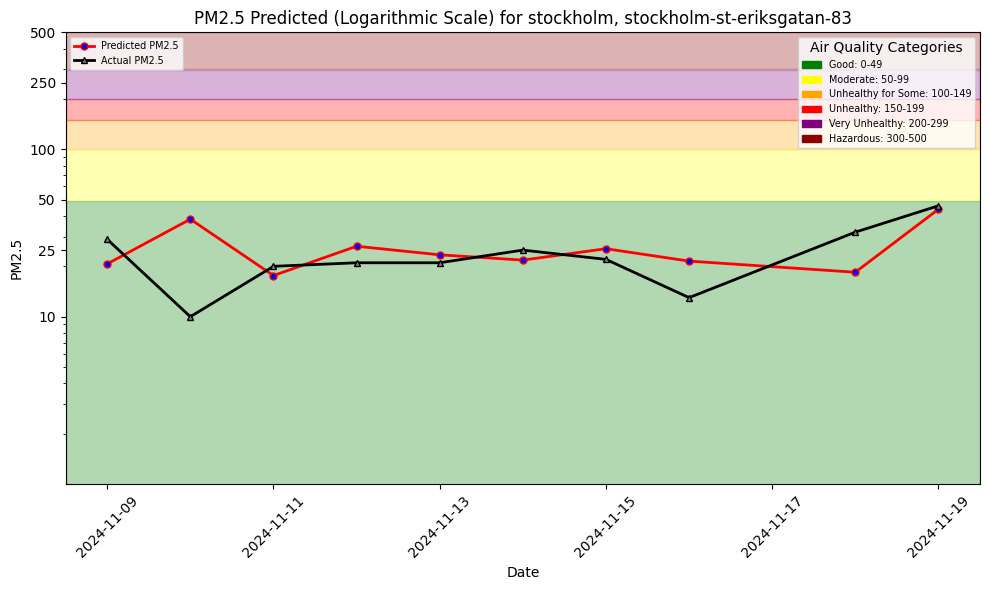

In [18]:
file_path=images_dir+"/pm25_hindcast.png"
plt=util.plot_air_quality_forecast(city, street, df.tail(10), file_path, hindcast=True)
plt.show()

In [19]:
df.tail(6)

,pm25,predicted_pm25,date
580,21.0,23.427866,2024-11-13 00:00:00+00:00
136,25.0,21.783355,2024-11-14 00:00:00+00:00
2138,22.0,25.480420,2024-11-15 00:00:00+00:00
2139,13.0,21.486837,2024-11-16 00:00:00+00:00
1588,32.0,18.435620,2024-11-18 00:00:00+00:00
581,46.0,43.850216,2024-11-19 00:00:00+00:00


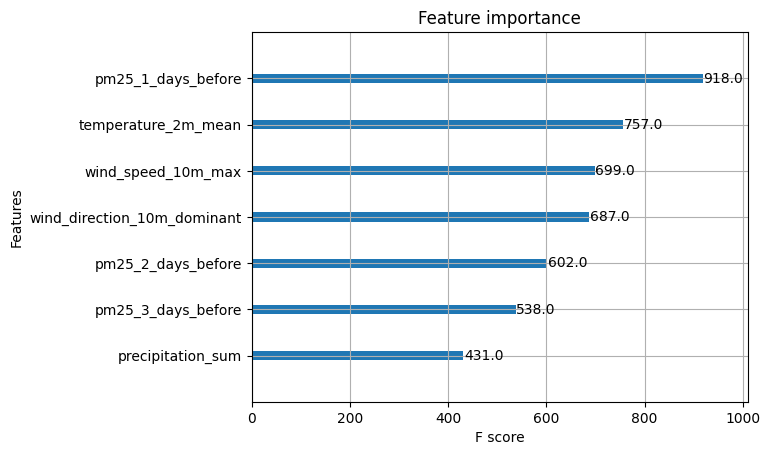

In [20]:
plot_importance(xgb_regressor, max_num_features=len(train_features.columns))
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [21]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [22]:
# Save XGBoost model 
xgb_regressor.save_model(model_dir + "/model.json")

# Save Gradient Boosting model (sklearn) to a json file
import joblib
joblib.dump(gb_regressor, model_dir + "/model.pkl")

['air_quality_model/model.pkl']

In [23]:
res_dict = { 
    "mse": results["gradient_boosting"]["mse"],
    "r2": results["gradient_boosting"]["r2"],
}

In [24]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_model",
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/519418 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/183980 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/26896 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/62614 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/131 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/973 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1157270/models/air_quality_model/1


Model(name: 'air_quality_model', version: 1)

## Experiment

We will experiment to try many models and features to get the best result. We will use the following models:

- Linear Regression
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM

### Best Model

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

# Create a dictionary to store the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
}

# Create a dictionary to store the results
results = {}

# Iterate over the models
for model_name, model in models.items():
    model.fit(train_features, y_train)
    y_pred = model.predict(test_features)
    mse = mean_squared_error(y_test.iloc[:,0], y_pred)
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    results[model_name] = {
        "MSE": mse,
        "R squared": r2,
    }

# Print the results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"MSE: {result['MSE']}")
    print(f"R squared: {result['R squared']}")
    print("")

# Choose the best model
best_model_name = min(results, key=lambda x: results[x]["MSE"])
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 1680, number of used features: 7
[LightGBM] [Info] Start training from score 24.931548
Model: Linear Regression
MSE: 67.96775817871094
R squared: 0.4801836107643349

Model: Random Forest
MSE: 66.00458217391305
R squared: 0.4951979757738224

Model: Gradient Boosting
MSE: 62.70452415921515
R squared: 0.520436768460881

Model: XGBoost
MSE: 71.09024810791016
R squared: 0.4563028491476222

Model: LightGBM
MSE: 67.63812529386855
R squared: 0.4827046632422539

Best model: Gradient Boosting


### Best Dataset

In [26]:
# Let's see which dataset has the lowest MSE

datasets = {
    "1": {
        "train_features": X_train.drop(['date', 'city', 'pm25_avg_3_days_before'], axis=1),
        "test_features": X_test.drop(['date', 'city', 'pm25_avg_3_days_before'], axis=1),
    },
    "2": {
        "train_features": X_train.drop(['date', 'city', 'pm25_avg_3_days_before', 'pm25_3_days_before'], axis=1),
        "test_features": X_test.drop(['date', 'city', 'pm25_avg_3_days_before', 'pm25_3_days_before'], axis=1),
    },
    "3": {
        "train_features": X_train.drop(['date', 'city', 'pm25_avg_3_days_before', 'pm25_3_days_before', 'pm25_2_days_before'], axis=1),
        "test_features": X_test.drop(['date', 'city', 'pm25_avg_3_days_before', 'pm25_3_days_before', 'pm25_2_days_before'], axis=1),
    },
    "4": {
        "train_features": X_train.drop(['date', 'city', 'pm25_avg_3_days_before', 'pm25_3_days_before', 'pm25_2_days_before', 'pm25_1_days_before'], axis=1),
        "test_features": X_test.drop(['date', 'city', 'pm25_avg_3_days_before', 'pm25_3_days_before', 'pm25_2_days_before', 'pm25_1_days_before'], axis=1),
    },
}

results = {}

for dataset_name, dataset in datasets.items():

    model = XGBRegressor()
    model.fit(dataset["train_features"], y_train)
    y_pred = model.predict(dataset["test_features"])
    mse = mean_squared_error(y_test.iloc[:,0], y_pred)
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    results[dataset_name] = {
        "MSE": mse,
        "R squared": r2,
    }

# Print the results
for dataset_name, result in results.items():
    print(f"Dataset: {dataset_name}")
    print(f"MSE: {result['MSE']}")
    print(f"R squared: {result['R squared']}")
    print("")

# Let's see which dataset has the lowest MSE
best_dataset = min(results, key=lambda x: results[x]["MSE"])
print(f"Best dataset configuration: {best_dataset}")
print(f"Features: {datasets[best_dataset]['train_features'].columns}")

Dataset: 1
MSE: 71.09024810791016
R squared: 0.4563028491476222

Dataset: 2
MSE: 76.22045135498047
R squared: 0.4170672611743881

Dataset: 3
MSE: 73.3883056640625
R squared: 0.43872734355789866

Dataset: 4
MSE: 178.9420166015625
R squared: -0.36854584614969865

Best dataset configuration: 1
Features: Index(['pm25_1_days_before', 'pm25_2_days_before', 'pm25_3_days_before',
       'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant'],
      dtype='object')


We will choose Gradient Boosting as the best model and use the following features: 'pm25_1_days_before', 'pm25_2_days_before', 'pm25_3_days_before',
       'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant'.